# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/vit_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546  1.133091  0.217425 -0.231097 -0.182072 -0.504708  0.070857   
      201547  1.133091  0.217425 -0.231097 -0.182072 -0.504708  0.070857   
      201548  1.133091  0.217425 -0.231097 -0.182072 -0.504708  0.070857   
      201549  1.133091  0.217425 -0.231097 -0.182072 -0.504708  0.070857   
      201550  1.133091  0.217425 -0.231097 -0.182072 -0.504708  0.070857   

                     6         7         8         9  ...       759      760  \
41001 201546 -0.043583  0.039565  1.068861 -1.013094  ... -1.350291  0.30233   
      201547 -0.043583  0.039565  1.068861 -1.013094  ... -1.350291  0.30233   
      201548 -0.043583  0.039565  1.068861 -1.013094  ... -1.350291  0.30233   
      201549 -0.043583  0.039565  1.068861 -1.013094  ... -1.350291  0.30233   
      201550 -0.043583  0.039565  1.068861 -1.013094  ... -1.350291  0.30233   

                   761       762       763       764       765       766  \
41001 201546  1.289005  0.532868  1.015604  1.075127 -0.936871  0.669691   
      201547  1.289005  0.532868  1.015604  1.075127 -0.936871  0.669691   
      201548  1.289005  0.532868  1.015604  1.075127 -0.936871  0.669691   
      201549  1.289005  0.532868  1.015604  1.075127 -0.936871  0.669691   
      201550  1.289005  0.532868  1.015604  1.075127 -0.936871  0.669691   

                   767    Labels  
41001 201546 -0.031982  0.064361  
      201547 -0.031982  0.091926  
      201548 -0.031982  0.082738  
      201549 -0.031982  0.082738  
      201550 -0.031982  0.211376  

[5 rows x 769 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820 -1.814292  0.411694  0.034540  0.407059 -1.031293  0.063479   
      201821 -0.192365 -1.385297 -1.321689  0.318072  0.543745 -0.058522   
      201822 -0.838178 -1.398852 -0.555425 -0.615352 -1.116069 -2.283523   
      201823 -0.191374  0.918630  0.767587 -0.706807  2.384467  0.262304   
      201824  0.454048 -0.349019 -1.444569  1.229523 -0.663905  2.191633   

                     6         7         8         9  ...       759       760  \
41001 201820  1.496953 -1.374667  0.167430  0.789208  ...  1.282570 -0.059619   
      201821  1.288059 -2.160279 -0.689726  0.101171  ...  0.803735  1.691648   
      201822  0.831736 -1.976944 -1.675258  0.010261  ...  1.190938  0.243573   
      201823 -2.047614 -0.243939 -0.348121  0.071171  ... -0.513067 -0.917373   
      201824  0.629332  0.168395 -0.480117  0.935277  ...  0.700491  2.076775   

                   761       762       763       764       765       766  \
41001 201820 -2.326366  0.126393 -0.123938 -1.771605  2.070463 -0.588392   
      201821 -0.780127 -1.441568 -0.251815 -0.016223  0.059928  0.246481   
      201822 -0.621182 -1.049071 -0.748401  0.902635  1.702769 -0.348538   
      201823 -0.024179 -0.474245 -1.304415  0.917566  1.787579 -0.854313   
      201824 -1.231876  0.531752  0.051081 -1.643207 -0.722104  1.279971   

                   767    Labels  
41001 201820 -0.523229 -0.275610  
      201821  2.951011 -0.321552  
      201822  0.589809 -0.238856  
      201823 -0.838693 -0.321552  
      201824  1.159521 -0.293986  

[5 rows x 769 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 769)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 769)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 768)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 768)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

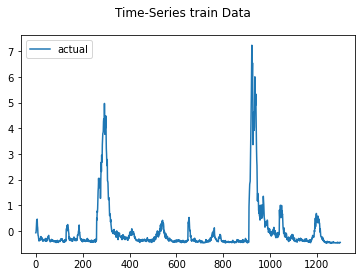

2023-03-15 03:58:11.989192: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-15 03:58:11.989230: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-15 03:58:11.989270: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-15 03:58:11.989473: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 03:58:12.077269: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 39.118
Test RMSE: 47.625
Test sMAPE: 96.622
Test R Squared: -1.347
{'mae': 39.11790123907002, 'rmse': 47.62549700283881, 'smape': 96.62230208055797, 'r2': -1.3470429838814852}


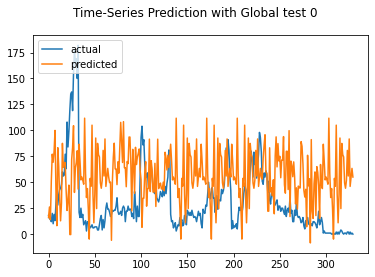

Test MAE: 38.879
Test RMSE: 47.220
Test sMAPE: 97.044
Test R Squared: -1.307
{'mae': 38.87913697190357, 'rmse': 47.22041614842088, 'smape': 97.04373527547499, 'r2': -1.3072870150751306}


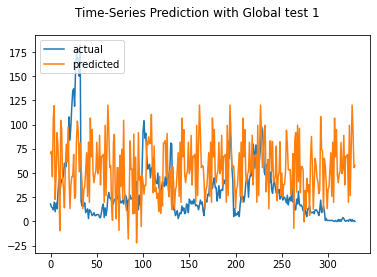

Test MAE: 36.390
Test RMSE: 44.264
Test sMAPE: 90.938
Test R Squared: -1.027
{'mae': 36.389805760528105, 'rmse': 44.26410682118506, 'smape': 90.93842054599949, 'r2': -1.0274278699841006}


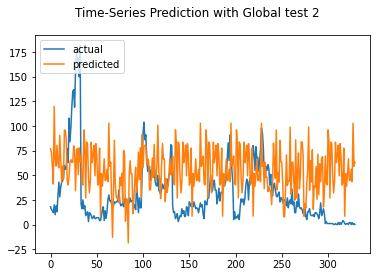

Test MAE: 38.060
Test RMSE: 49.037
Test sMAPE: 97.902
Test R Squared: -1.488
{'mae': 38.05983255451376, 'rmse': 49.03737268368167, 'smape': 97.90204167658992, 'r2': -1.4882636135257465}


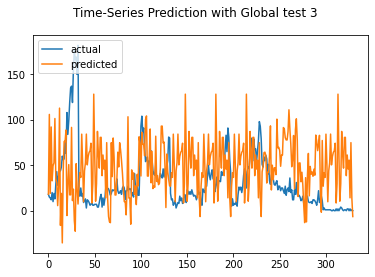

Test MAE: 34.401
Test RMSE: 42.915
Test sMAPE: 98.900
Test R Squared: -0.906
{'mae': 34.401059515187235, 'rmse': 42.91491366059733, 'smape': 98.90030586081548, 'r2': -0.9057173500359841}


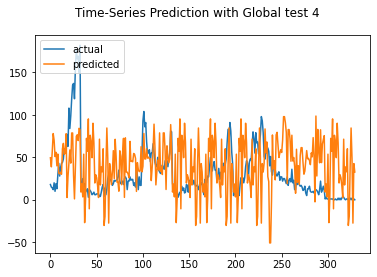

Test MAE: 42.208
Test RMSE: 50.553
Test sMAPE: 97.829
Test R Squared: -1.645
{'mae': 42.20763779120012, 'rmse': 50.553462587413904, 'smape': 97.82902494067959, 'r2': -1.6445014916345522}


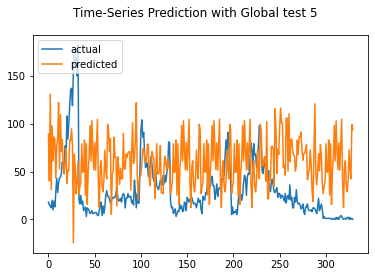

Test MAE: 33.913
Test RMSE: 42.106
Test sMAPE: 95.435
Test R Squared: -0.835
{'mae': 33.91258778106986, 'rmse': 42.10595030895065, 'smape': 95.43527911646318, 'r2': -0.8345474488519908}


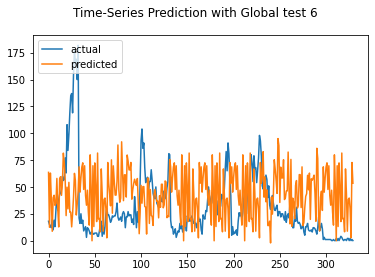

Test MAE: 38.577
Test RMSE: 48.512
Test sMAPE: 94.562
Test R Squared: -1.435
{'mae': 38.57695576656948, 'rmse': 48.5118626513804, 'smape': 94.56165423883914, 'r2': -1.4352183168799093}


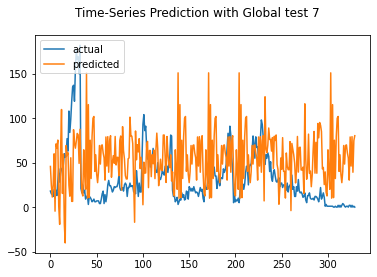

Test MAE: 30.771
Test RMSE: 38.990
Test sMAPE: 88.680
Test R Squared: -0.573
{'mae': 30.770843315937302, 'rmse': 38.990227132658525, 'smape': 88.67969823590194, 'r2': -0.5730898609695072}


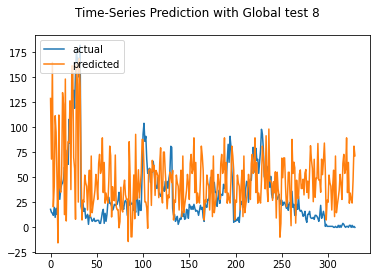

Test MAE: 35.276
Test RMSE: 42.697
Test sMAPE: 94.085
Test R Squared: -0.886
{'mae': 35.27568468325066, 'rmse': 42.697080540612866, 'smape': 94.08458098475242, 'r2': -0.8864198732615736}


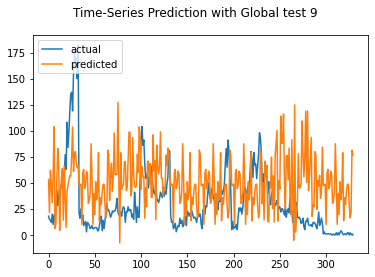

Test MAE: 39.139
Test RMSE: 46.597
Test sMAPE: 96.470
Test R Squared: -1.247
{'mae': 39.13911221713731, 'rmse': 46.597077744408445, 'smape': 96.47044371252862, 'r2': -1.24677387157337}


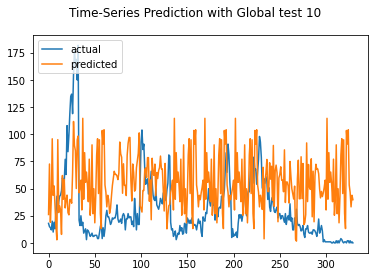

Test MAE: 35.801
Test RMSE: 43.366
Test sMAPE: 95.148
Test R Squared: -0.946
{'mae': 35.800686570369834, 'rmse': 43.365925565881696, 'smape': 95.14766810699267, 'r2': -0.9459838951337416}


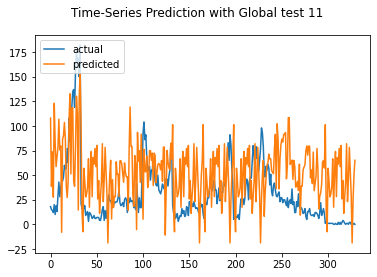

Test MAE: 35.300
Test RMSE: 43.462
Test sMAPE: 93.262
Test R Squared: -0.955
{'mae': 35.30007213570855, 'rmse': 43.461554497300384, 'smape': 93.2619943171404, 'r2': -0.9545757810444373}


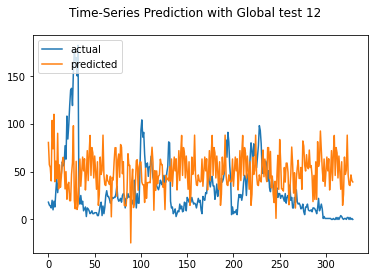

Test MAE: 39.494
Test RMSE: 48.115
Test sMAPE: 97.974
Test R Squared: -1.396
{'mae': 39.494428208741276, 'rmse': 48.11475813014843, 'smape': 97.97360793180857, 'r2': -1.395513460895521}


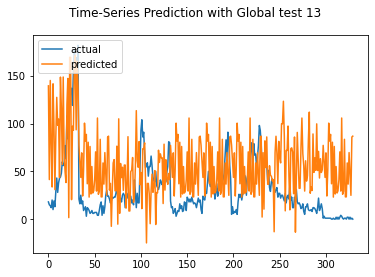

Test MAE: 34.563
Test RMSE: 43.037
Test sMAPE: 93.299
Test R Squared: -0.917
{'mae': 34.562536017461255, 'rmse': 43.036665950102154, 'smape': 93.29910377191041, 'r2': -0.916545967224804}


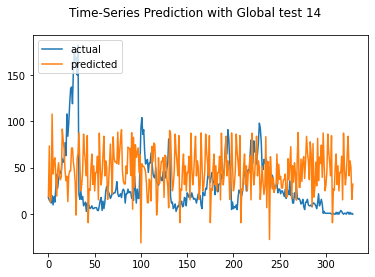

Test MAE: 35.212
Test RMSE: 44.589
Test sMAPE: 96.673
Test R Squared: -1.057
{'mae': 35.21190035185128, 'rmse': 44.58853406986869, 'smape': 96.67271173882365, 'r2': -1.0572562498817137}


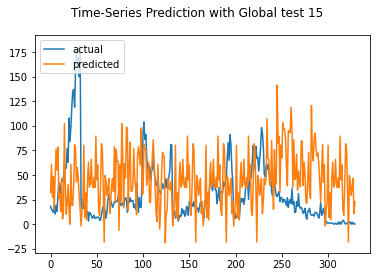

Test MAE: 39.691
Test RMSE: 48.184
Test sMAPE: 99.531
Test R Squared: -1.402
{'mae': 39.69119635820389, 'rmse': 48.18440796935207, 'smape': 99.53074485176482, 'r2': -1.4024538632136632}


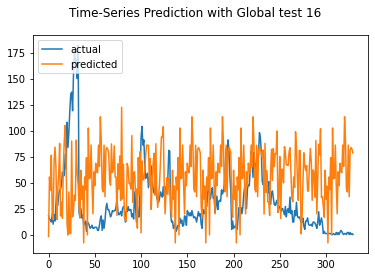

Test MAE: 36.980
Test RMSE: 46.416
Test sMAPE: 94.848
Test R Squared: -1.229
{'mae': 36.980008879033, 'rmse': 46.416225841478344, 'smape': 94.84803844476258, 'r2': -1.2293674236911372}


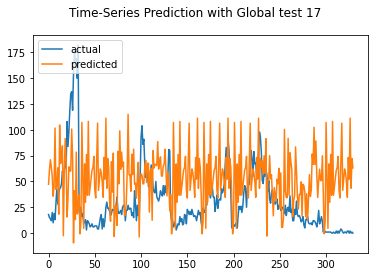

Test MAE: 44.582
Test RMSE: 55.185
Test sMAPE: 103.570
Test R Squared: -2.151
{'mae': 44.58196512162685, 'rmse': 55.18542186085048, 'smape': 103.57002259982264, 'r2': -2.1513071536014174}


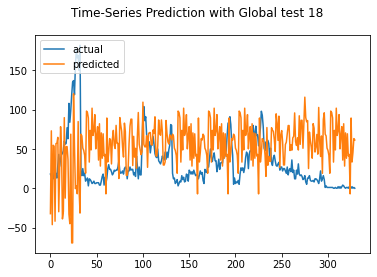

Test MAE: 36.582
Test RMSE: 43.573
Test sMAPE: 93.801
Test R Squared: -0.965
{'mae': 36.581940183370854, 'rmse': 43.57273149883774, 'smape': 93.80054732963315, 'r2': -0.9645883917137557}


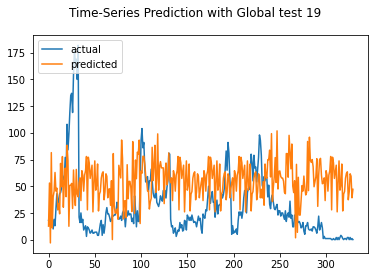

Test MAE: 33.208
Test RMSE: 42.663
Test sMAPE: 106.791
Test R Squared: -0.883
{'mae': 33.20817164363283, 'rmse': 42.66299858510607, 'smape': 106.79144711209736, 'r2': -0.8834094932906931}


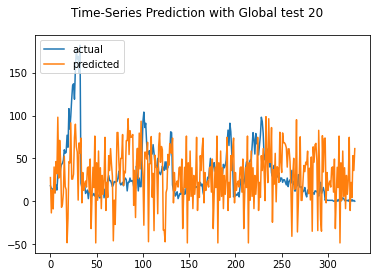

Test MAE: 32.426
Test RMSE: 39.607
Test sMAPE: 96.563
Test R Squared: -0.623
{'mae': 32.42592576982623, 'rmse': 39.607037524275576, 'smape': 96.56309695626128, 'r2': -0.6232548954922976}


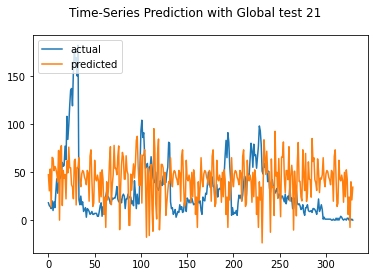

Test MAE: 34.987
Test RMSE: 45.649
Test sMAPE: 102.722
Test R Squared: -1.156
{'mae': 34.98728697254802, 'rmse': 45.649327036901234, 'smape': 102.72226947350269, 'r2': -1.1563078341385045}


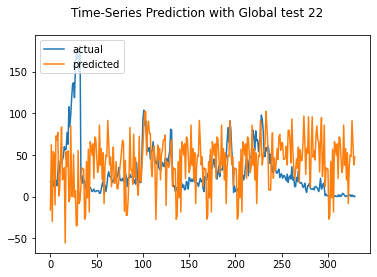

Test MAE: 37.734
Test RMSE: 45.126
Test sMAPE: 93.604
Test R Squared: -1.107
{'mae': 37.73364288445675, 'rmse': 45.12596820227791, 'smape': 93.60418611932568, 'r2': -1.1071481332815156}


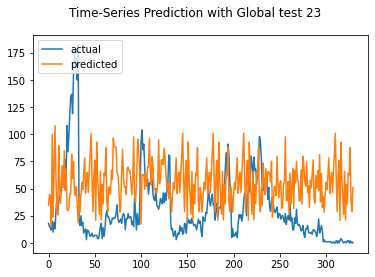

Test MAE: 34.299
Test RMSE: 42.127
Test sMAPE: 94.272
Test R Squared: -0.836
{'mae': 34.298962541060014, 'rmse': 42.12742492196756, 'smape': 94.2716816434614, 'r2': -0.8364192148393061}


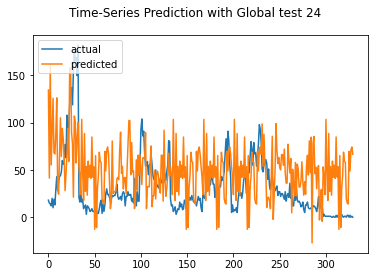

Test MAE: 32.443
Test RMSE: 39.361
Test sMAPE: 93.168
Test R Squared: -0.603
{'mae': 32.4430905520916, 'rmse': 39.36060610784321, 'smape': 93.16788325055896, 'r2': -0.6031182439906491}


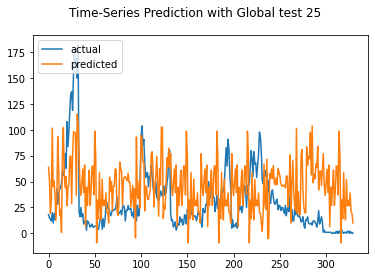

Test MAE: 40.715
Test RMSE: 48.986
Test sMAPE: 98.913
Test R Squared: -1.483
{'mae': 40.71545948693247, 'rmse': 48.985874368809824, 'smape': 98.91349350438722, 'r2': -1.4830400833909518}


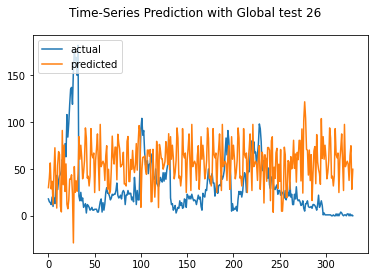

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 41.807
Test RMSE: 54.865
Test sMAPE: 116.708
Test R Squared: -2.115
{'mae': 41.80679604754303, 'rmse': 54.864845213754656, 'smape': 116.70776176494785, 'r2': -2.114801091787562}


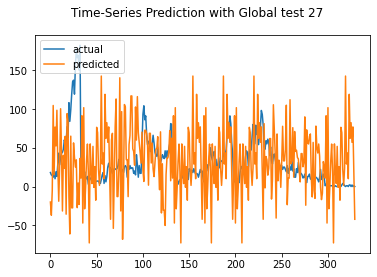

Test MAE: 32.427
Test RMSE: 41.274
Test sMAPE: 93.382
Test R Squared: -0.763
{'mae': 32.4267107847062, 'rmse': 41.27387300668425, 'smape': 93.38204371092247, 'r2': -0.7627570034999855}


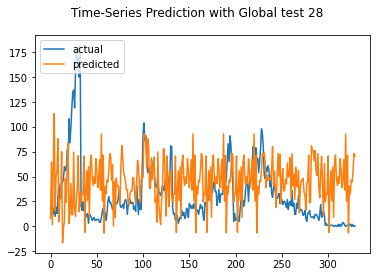

Test MAE: 42.419
Test RMSE: 49.302
Test sMAPE: 98.592
Test R Squared: -1.515
{'mae': 42.418864623705545, 'rmse': 49.30215840875787, 'smape': 98.59158856817136, 'r2': -1.515207776881546}


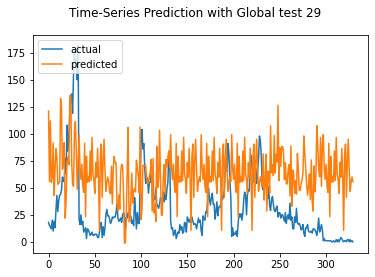

Test MAE: 35.130
Test RMSE: 43.534
Test sMAPE: 92.047
Test R Squared: -0.961
{'mae': 35.12984300549283, 'rmse': 43.53421275081222, 'smape': 92.04720944903127, 'r2': -0.9611164938290835}


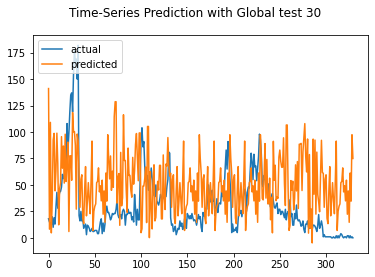

Test MAE: 36.258
Test RMSE: 44.837
Test sMAPE: 92.875
Test R Squared: -1.080
{'mae': 36.257798716516206, 'rmse': 44.83740505899034, 'smape': 92.87520265254012, 'r2': -1.0802854993954374}


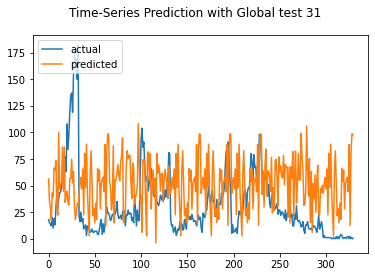

Test MAE: 31.160
Test RMSE: 38.151
Test sMAPE: 88.818
Test R Squared: -0.506
{'mae': 31.159694982749045, 'rmse': 38.15118991185192, 'smape': 88.81839645387174, 'r2': -0.5061151510686281}


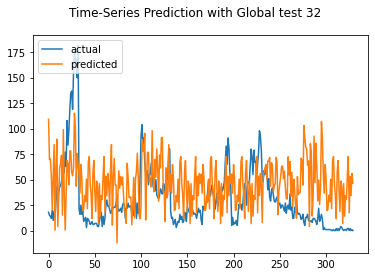

Test MAE: 35.505
Test RMSE: 44.648
Test sMAPE: 90.263
Test R Squared: -1.063
{'mae': 35.50538609678095, 'rmse': 44.648065384206305, 'smape': 90.26332486755118, 'r2': -1.062753309978722}


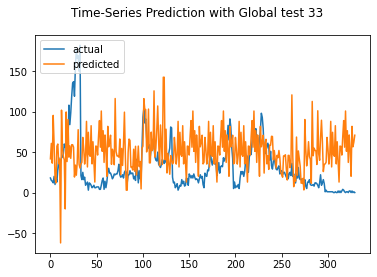

Test MAE: 34.138
Test RMSE: 44.882
Test sMAPE: 98.300
Test R Squared: -1.084
{'mae': 34.13834405568513, 'rmse': 44.88163326455604, 'smape': 98.300120479874, 'r2': -1.0843915654438088}


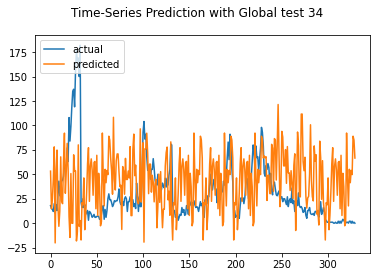

Test MAE: 34.610
Test RMSE: 43.111
Test sMAPE: 95.144
Test R Squared: -0.923
{'mae': 34.60974599375869, 'rmse': 43.11060054632006, 'smape': 95.1444980386715, 'r2': -0.9231366621418238}


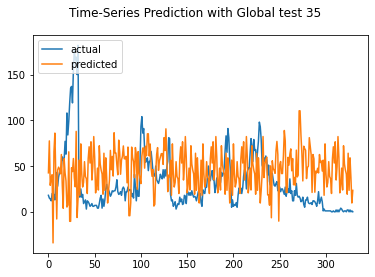

Test MAE: 35.322
Test RMSE: 42.704
Test sMAPE: 94.552
Test R Squared: -0.887
{'mae': 35.32155122558276, 'rmse': 42.70360552499612, 'smape': 94.55225914518063, 'r2': -0.8869964841483053}


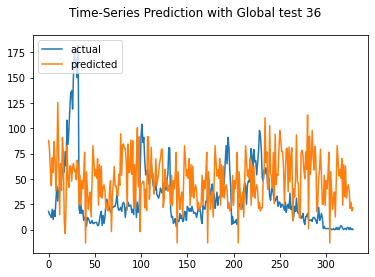

Test MAE: 40.451
Test RMSE: 49.527
Test sMAPE: 97.989
Test R Squared: -1.538
{'mae': 40.45084207816557, 'rmse': 49.526855340486755, 'smape': 97.98925750726846, 'r2': -1.538186378995127}


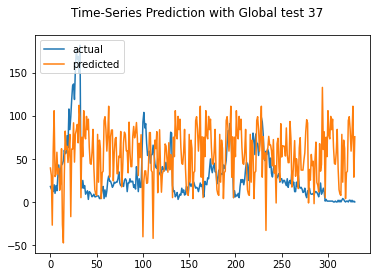

Test MAE: 40.793
Test RMSE: 50.602
Test sMAPE: 102.251
Test R Squared: -1.650
{'mae': 40.793257012782675, 'rmse': 50.60241548413901, 'smape': 102.25063996528506, 'r2': -1.6496255199578598}


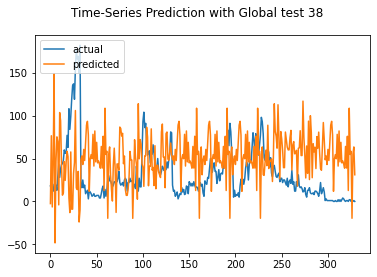

Test MAE: 35.226
Test RMSE: 45.167
Test sMAPE: 97.760
Test R Squared: -1.111
{'mae': 35.225660692923, 'rmse': 45.167473322056274, 'smape': 97.76035326979533, 'r2': -1.1110260625152257}


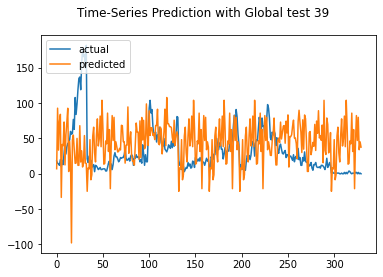

Test MAE: 41.144
Test RMSE: 51.305
Test sMAPE: 94.021
Test R Squared: -1.724
{'mae': 41.1441388130188, 'rmse': 51.305300407099395, 'smape': 94.02070174665248, 'r2': -1.723745159228526}


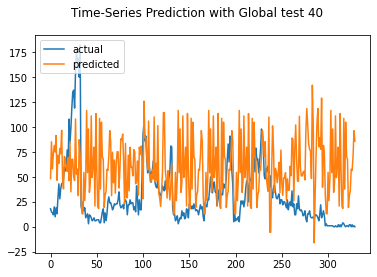

Test MAE: 37.459
Test RMSE: 46.694
Test sMAPE: 100.361
Test R Squared: -1.256
{'mae': 37.45938299117666, 'rmse': 46.69447041726181, 'smape': 100.36109198563325, 'r2': -1.256175662443482}


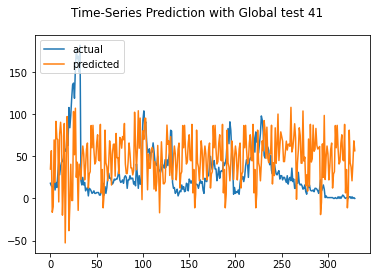

Test MAE: 36.753
Test RMSE: 45.664
Test sMAPE: 95.505
Test R Squared: -1.158
{'mae': 36.75315154285142, 'rmse': 45.664466253780816, 'smape': 95.50536230691338, 'r2': -1.157738314159512}


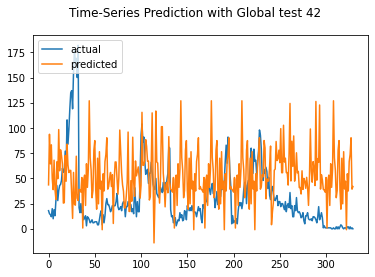

Test MAE: 36.444
Test RMSE: 43.839
Test sMAPE: 95.059
Test R Squared: -0.989
{'mae': 36.4438187535062, 'rmse': 43.83909345457011, 'smape': 95.05871035463396, 'r2': -0.988681031310233}


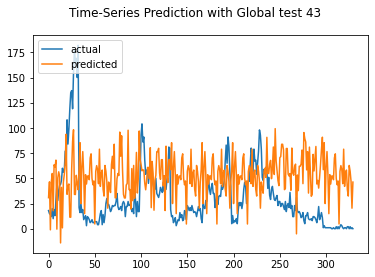

Test MAE: 38.262
Test RMSE: 45.916
Test sMAPE: 94.924
Test R Squared: -1.182
{'mae': 38.26174220316338, 'rmse': 45.91632648721762, 'smape': 94.92401535377368, 'r2': -1.1816057630782808}


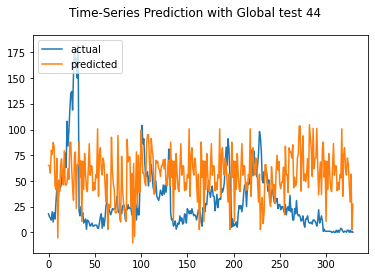

Test MAE: 33.583
Test RMSE: 42.159
Test sMAPE: 95.440
Test R Squared: -0.839
{'mae': 33.583007570107775, 'rmse': 42.159183250798435, 'smape': 95.44007523452115, 'r2': -0.8391890774012638}


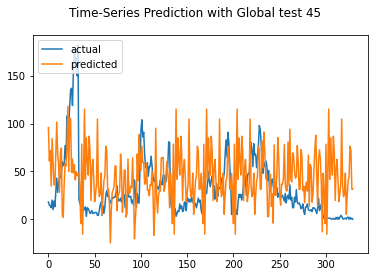

Test MAE: 28.958
Test RMSE: 36.487
Test sMAPE: 84.275
Test R Squared: -0.378
{'mae': 28.95802097054142, 'rmse': 36.48747988761807, 'smape': 84.27487214510609, 'r2': -0.3776209507586612}


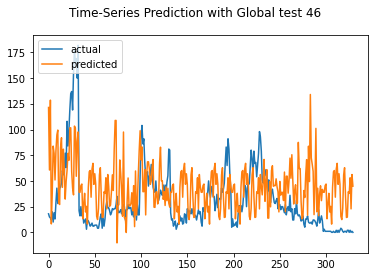

Test MAE: 34.712
Test RMSE: 43.153
Test sMAPE: 91.945
Test R Squared: -0.927
{'mae': 34.71165317531788, 'rmse': 43.15262669384683, 'smape': 91.94501226041719, 'r2': -0.9268880095376206}


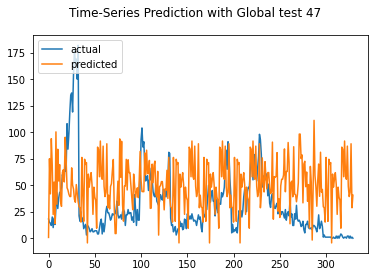

Test MAE: 37.119
Test RMSE: 46.344
Test sMAPE: 92.774
Test R Squared: -1.222
{'mae': 37.119206862377396, 'rmse': 46.34372232743735, 'smape': 92.77388514158993, 'r2': -1.2224081878412334}


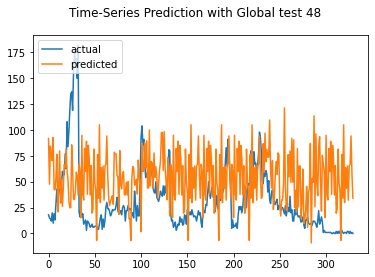

Test MAE: 38.097
Test RMSE: 45.713
Test sMAPE: 95.231
Test R Squared: -1.162
{'mae': 38.097424202615564, 'rmse': 45.71251624691273, 'smape': 95.23091570638819, 'r2': -1.1622816217885}


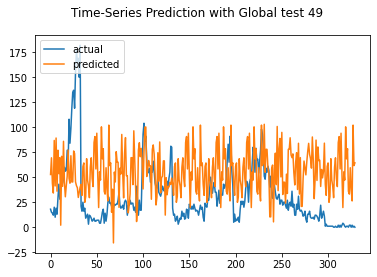

Test MAE: 37.087
Test RMSE: 44.400
Test sMAPE: 100.701
Test R Squared: -1.040
{'mae': 37.08723402828204, 'rmse': 44.39999712071008, 'smape': 100.7008334351161, 'r2': -1.0398953386938188}


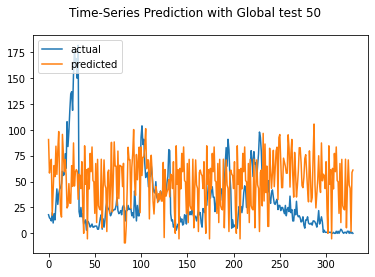

Test MAE: 32.949
Test RMSE: 41.814
Test sMAPE: 90.476
Test R Squared: -0.809
{'mae': 32.9488779900652, 'rmse': 41.814208622489616, 'smape': 90.47645469664762, 'r2': -0.809213272551843}


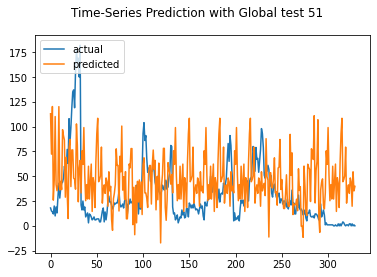

Test MAE: 47.757
Test RMSE: 59.786
Test sMAPE: 108.209
Test R Squared: -2.699
{'mae': 47.75714688734575, 'rmse': 59.78576240133891, 'smape': 108.20901771593785, 'r2': -2.698601533001295}


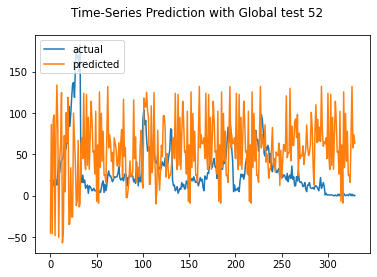

Test MAE: 31.255
Test RMSE: 40.408
Test sMAPE: 104.170
Test R Squared: -0.690
{'mae': 31.25481398791978, 'rmse': 40.408037961519305, 'smape': 104.1699644329989, 'r2': -0.689575209545173}


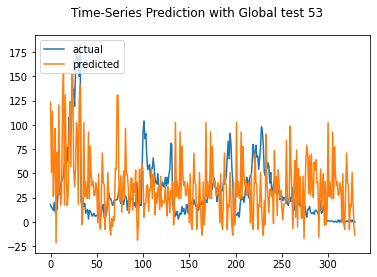

Test MAE: 41.251
Test RMSE: 51.109
Test sMAPE: 99.765
Test R Squared: -1.703
{'mae': 41.25144015984102, 'rmse': 51.108685983605056, 'smape': 99.76500957831361, 'r2': -1.7029090489696475}


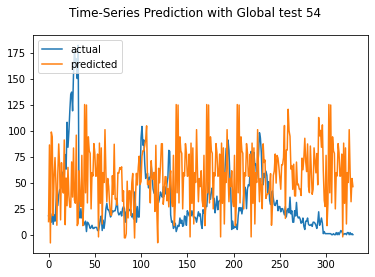

Test MAE: 37.825
Test RMSE: 45.057
Test sMAPE: 94.364
Test R Squared: -1.101
{'mae': 37.82490489266136, 'rmse': 45.05663251400195, 'smape': 94.36432803778723, 'r2': -1.100677875433885}


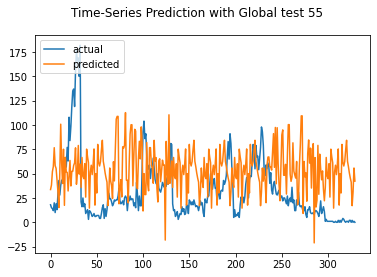

Test MAE: 33.441
Test RMSE: 42.886
Test sMAPE: 93.591
Test R Squared: -0.903
{'mae': 33.44063832299276, 'rmse': 42.88589778300571, 'smape': 93.59076318863458, 'r2': -0.9031412121346036}


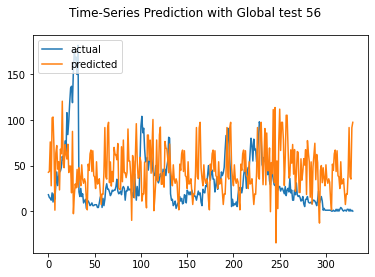

Test MAE: 35.030
Test RMSE: 45.496
Test sMAPE: 94.023
Test R Squared: -1.142
{'mae': 35.02959844199094, 'rmse': 45.49589207362779, 'smape': 94.02268767984259, 'r2': -1.1418367779877623}


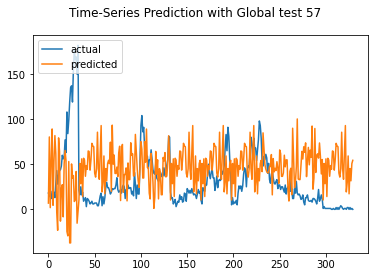

Test MAE: 33.996
Test RMSE: 42.272
Test sMAPE: 94.995
Test R Squared: -0.849
{'mae': 33.995828316609064, 'rmse': 42.271583391187384, 'smape': 94.99468326914032, 'r2': -0.8490090344462471}


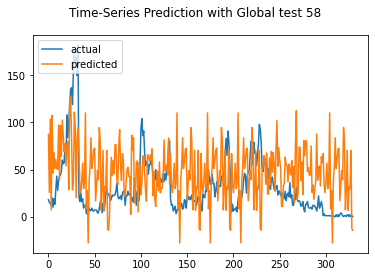

Test MAE: 38.087
Test RMSE: 50.642
Test sMAPE: 99.345
Test R Squared: -1.654
{'mae': 38.08732435766495, 'rmse': 50.641820042242955, 'smape': 99.34531946334714, 'r2': -1.6537537013190988}


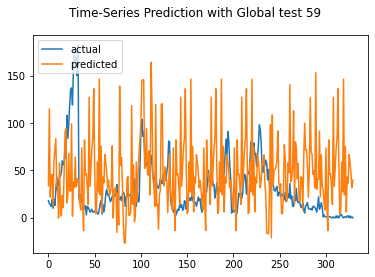

Test MAE: 35.272
Test RMSE: 44.716
Test sMAPE: 101.992
Test R Squared: -1.069
{'mae': 35.27150926436439, 'rmse': 44.716207610735445, 'smape': 101.99163693478154, 'r2': -1.0690544952353638}


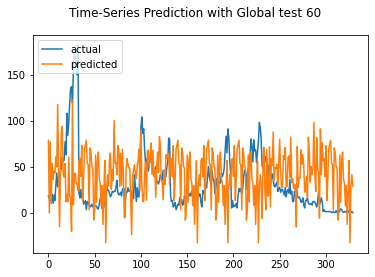

Test MAE: 34.224
Test RMSE: 41.865
Test sMAPE: 92.816
Test R Squared: -0.814
{'mae': 34.22415148092038, 'rmse': 41.865037191753096, 'smape': 92.81584966882555, 'r2': -0.8136144374872101}


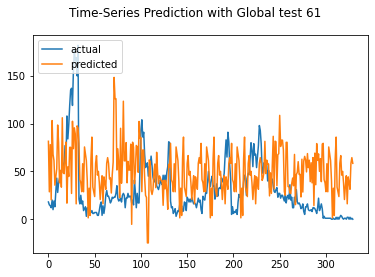

Test MAE: 41.984
Test RMSE: 50.849
Test sMAPE: 97.777
Test R Squared: -1.676
{'mae': 41.98418780962626, 'rmse': 50.848926259927865, 'smape': 97.7767365969869, 'r2': -1.6755038176977028}


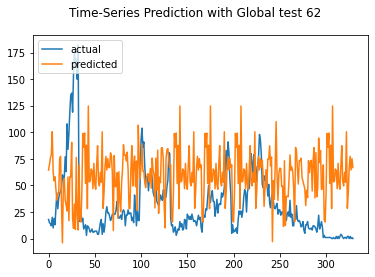

Test MAE: 33.606
Test RMSE: 43.098
Test sMAPE: 94.671
Test R Squared: -0.922
{'mae': 33.60616813807776, 'rmse': 43.09840938015922, 'smape': 94.67105492687169, 'r2': -0.9220491354881546}


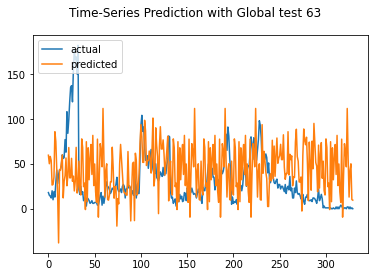

Test MAE: 37.075
Test RMSE: 49.056
Test sMAPE: 102.368
Test R Squared: -1.490
{'mae': 37.0750995539919, 'rmse': 49.055650653957684, 'smape': 102.36767056196175, 'r2': -1.4901188876548082}


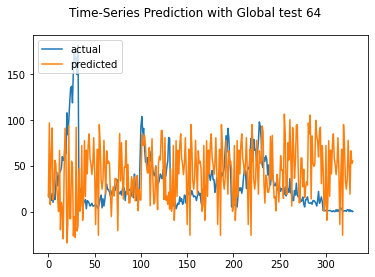

Test MAE: 39.697
Test RMSE: 46.016
Test sMAPE: 96.835
Test R Squared: -1.191
{'mae': 39.697369309627646, 'rmse': 46.01556875217456, 'smape': 96.83480692239414, 'r2': -1.1910464779777374}


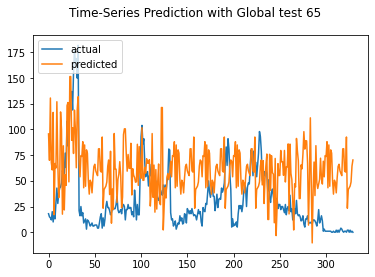

Test MAE: 37.130
Test RMSE: 46.419
Test sMAPE: 97.614
Test R Squared: -1.230
{'mae': 37.130243574353784, 'rmse': 46.41898910651952, 'smape': 97.61424296054774, 'r2': -1.2296328703673178}


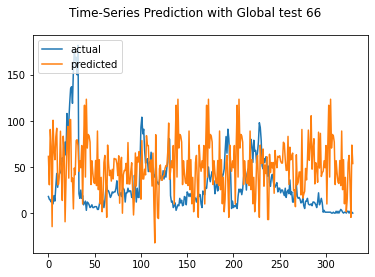

Test MAE: 35.639
Test RMSE: 44.916
Test sMAPE: 100.663
Test R Squared: -1.088
{'mae': 35.63871217062979, 'rmse': 44.91597602422892, 'smape': 100.66275310098338, 'r2': -1.0875826768540797}


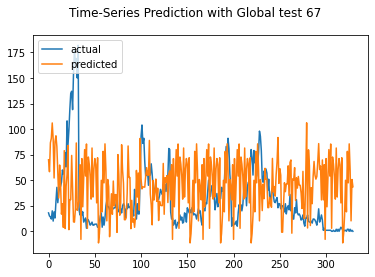

Test MAE: 35.911
Test RMSE: 42.698
Test sMAPE: 98.298
Test R Squared: -0.886
{'mae': 35.91052125918143, 'rmse': 42.69774384987883, 'smape': 98.29796617613104, 'r2': -0.8864784856765238}


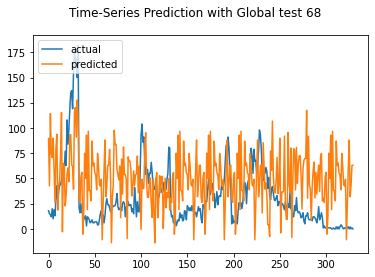

Test MAE: 37.539
Test RMSE: 45.207
Test sMAPE: 96.711
Test R Squared: -1.115
{'mae': 37.538951083927444, 'rmse': 45.20694998766517, 'smape': 96.71144014180827, 'r2': -1.1147177761334848}


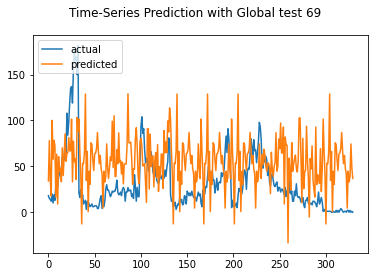

Test MAE: 36.199
Test RMSE: 45.626
Test sMAPE: 94.342
Test R Squared: -1.154
{'mae': 36.19903946419557, 'rmse': 45.62574296938325, 'smape': 94.34241313515714, 'r2': -1.1540803588951687}


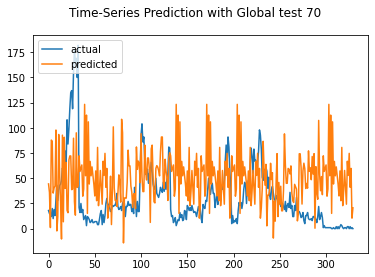

Test MAE: 35.072
Test RMSE: 46.780
Test sMAPE: 95.674
Test R Squared: -1.264
{'mae': 35.07225588307236, 'rmse': 46.78006107946011, 'smape': 95.67406131926064, 'r2': -1.2644543536769137}


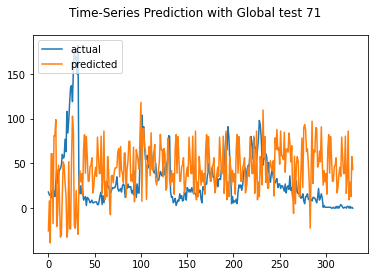

Test MAE: 37.060
Test RMSE: 45.501
Test sMAPE: 97.931
Test R Squared: -1.142
{'mae': 37.06042648400321, 'rmse': 45.50098473784163, 'smape': 97.93073406528134, 'r2': -1.1423163055010352}


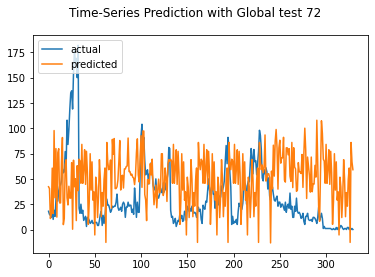

Test MAE: 32.112
Test RMSE: 40.910
Test sMAPE: 91.232
Test R Squared: -0.732
{'mae': 32.11176974087051, 'rmse': 40.90961049922144, 'smape': 91.23177216307681, 'r2': -0.731779884779779}


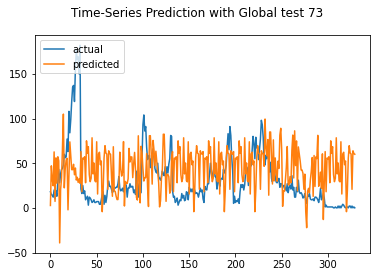

Test MAE: 37.386
Test RMSE: 44.637
Test sMAPE: 99.037
Test R Squared: -1.062
{'mae': 37.38612114046559, 'rmse': 44.63708598701138, 'smape': 99.0372394136313, 'r2': -1.0617389321751616}


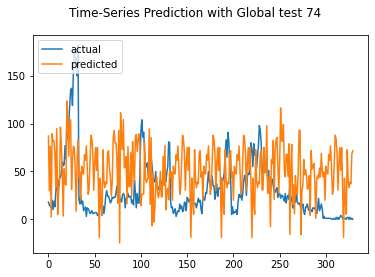

Test MAE: 34.452
Test RMSE: 44.092
Test sMAPE: 97.108
Test R Squared: -1.012
{'mae': 34.451729786802424, 'rmse': 44.092465559625275, 'smape': 97.1075567427438, 'r2': -1.0117349933910602}


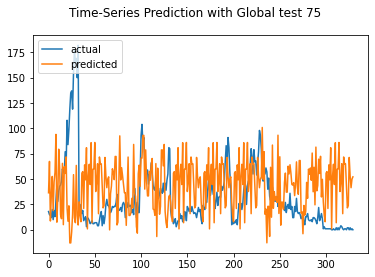

Test MAE: 41.047
Test RMSE: 51.474
Test sMAPE: 98.819
Test R Squared: -1.742
{'mae': 41.04659458529768, 'rmse': 51.47400333211382, 'smape': 98.8194321275739, 'r2': -1.741687135812052}


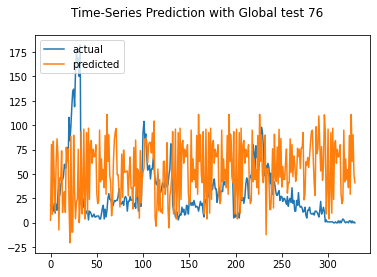

Test MAE: 39.442
Test RMSE: 48.302
Test sMAPE: 97.183
Test R Squared: -1.414
{'mae': 39.441783518050656, 'rmse': 48.30239146049566, 'smape': 97.18288710203275, 'r2': -1.4142334795359588}


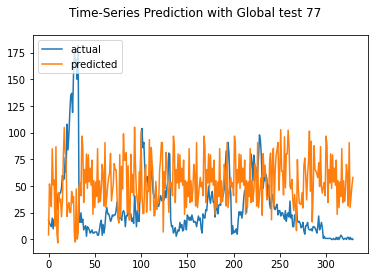

Test MAE: 41.961
Test RMSE: 53.233
Test sMAPE: 98.936
Test R Squared: -1.932
{'mae': 41.96124837181785, 'rmse': 53.2333715345551, 'smape': 98.93649065302424, 'r2': -1.9323104481420672}


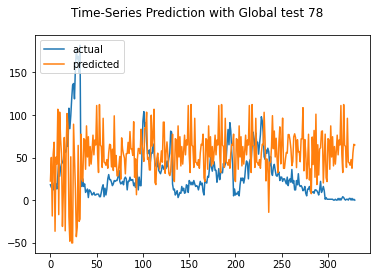

Test MAE: 38.694
Test RMSE: 46.784
Test sMAPE: 96.403
Test R Squared: -1.265
{'mae': 38.69415200623599, 'rmse': 46.784422870004484, 'smape': 96.40274004290494, 'r2': -1.2648766505201081}


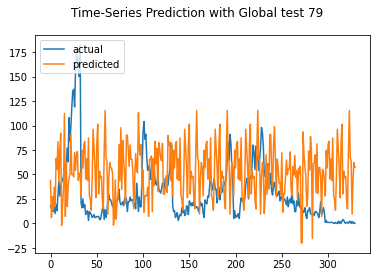

Test MAE: 31.145
Test RMSE: 38.498
Test sMAPE: 89.701
Test R Squared: -0.534
{'mae': 31.14452590567596, 'rmse': 38.497896480693186, 'smape': 89.70127076148576, 'r2': -0.5336137808721981}


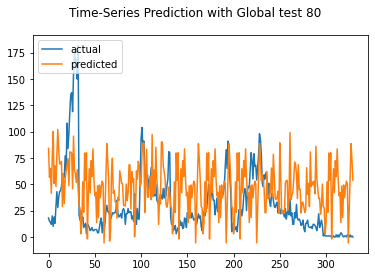

Test MAE: 41.032
Test RMSE: 49.095
Test sMAPE: 100.058
Test R Squared: -1.494
{'mae': 41.03230452971025, 'rmse': 49.095437595772744, 'smape': 100.05801426954945, 'r2': -1.4941597837149123}


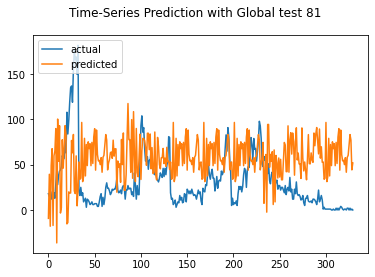

Test MAE: 36.329
Test RMSE: 45.646
Test sMAPE: 94.430
Test R Squared: -1.156
{'mae': 36.32878876924515, 'rmse': 45.64608074871295, 'smape': 94.42968781936541, 'r2': -1.1560011593982997}


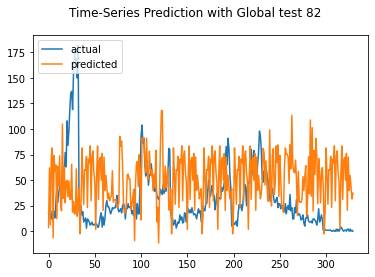

Test MAE: 45.991
Test RMSE: 58.244
Test sMAPE: 103.431
Test R Squared: -2.510
{'mae': 45.99050813010245, 'rmse': 58.244099387484695, 'smape': 103.43073131540767, 'r2': -2.5103132246603863}


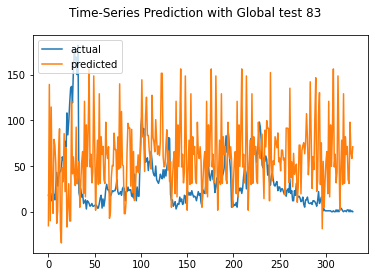

Test MAE: 42.828
Test RMSE: 50.603
Test sMAPE: 97.339
Test R Squared: -1.650
{'mae': 42.827569260922346, 'rmse': 50.60326911602133, 'smape': 97.3387837205042, 'r2': -1.6497149158444415}


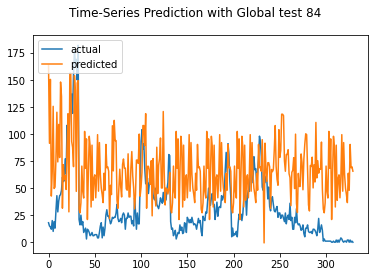

Test MAE: 38.937
Test RMSE: 46.008
Test sMAPE: 99.035
Test R Squared: -1.190
{'mae': 38.93732274698489, 'rmse': 46.008498227999176, 'smape': 99.035131173519, 'r2': -1.190373199028382}


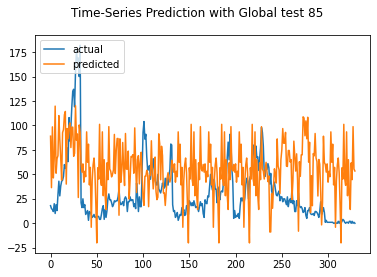

Test MAE: 33.253
Test RMSE: 42.434
Test sMAPE: 90.500
Test R Squared: -0.863
{'mae': 33.253356959603046, 'rmse': 42.43393653836844, 'smape': 90.49984302742159, 'r2': -0.8632393465721417}


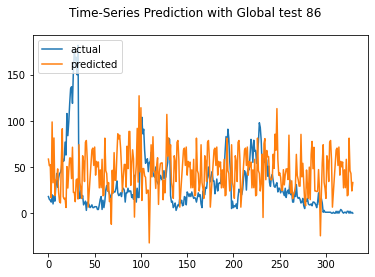

Test MAE: 34.733
Test RMSE: 42.828
Test sMAPE: 98.178
Test R Squared: -0.898
{'mae': 34.73258883980188, 'rmse': 42.82809063821161, 'smape': 98.17785556905872, 'r2': -0.8980140715599383}


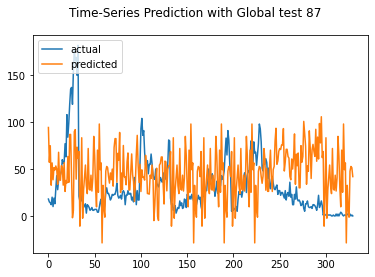

Test MAE: 39.793
Test RMSE: 49.039
Test sMAPE: 92.999
Test R Squared: -1.488
{'mae': 39.79348350004717, 'rmse': 49.039239365266, 'smape': 92.99945642759408, 'r2': -1.488453056149432}


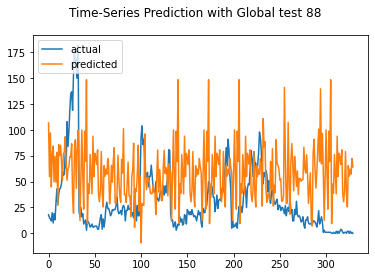

Test MAE: 45.856
Test RMSE: 54.341
Test sMAPE: 105.301
Test R Squared: -2.056
{'mae': 45.85574872584054, 'rmse': 54.34069742117579, 'smape': 105.301499029851, 'r2': -2.055571267539116}


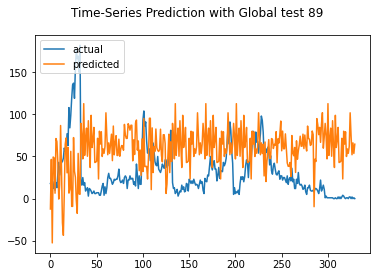

Test MAE: 35.657
Test RMSE: 43.930
Test sMAPE: 97.820
Test R Squared: -0.997
{'mae': 35.6567240886616, 'rmse': 43.93004373265633, 'smape': 97.82004509855292, 'r2': -0.9969411799417678}


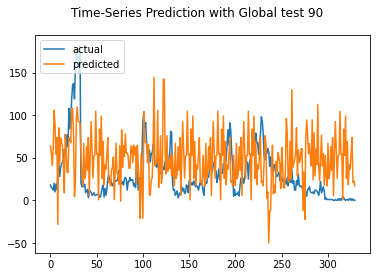

Test MAE: 35.580
Test RMSE: 46.740
Test sMAPE: 100.143
Test R Squared: -1.261
{'mae': 35.579931454089554, 'rmse': 46.74026950632718, 'smape': 100.14258804889192, 'r2': -1.2606036584730842}


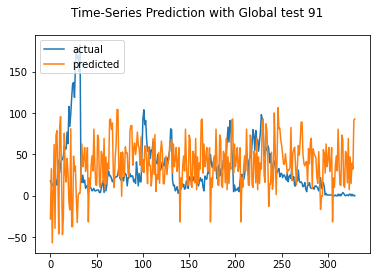

Test MAE: 31.528
Test RMSE: 40.771
Test sMAPE: 94.326
Test R Squared: -0.720
{'mae': 31.527853854497273, 'rmse': 40.77050451467901, 'smape': 94.32610546793903, 'r2': -0.7200226779936467}


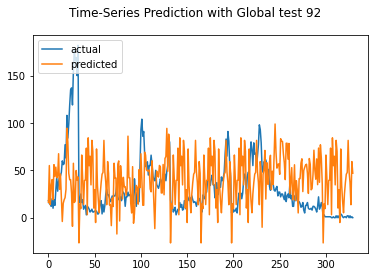

Test MAE: 37.527
Test RMSE: 44.114
Test sMAPE: 93.740
Test R Squared: -1.014
{'mae': 37.52729735807939, 'rmse': 44.11414111562382, 'smape': 93.73980940858294, 'r2': -1.0137133900185638}


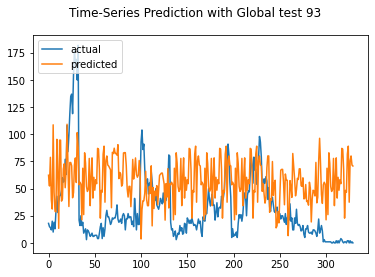

Test MAE: 37.198
Test RMSE: 49.642
Test sMAPE: 97.621
Test R Squared: -1.550
{'mae': 37.19769696051424, 'rmse': 49.641759437016084, 'smape': 97.62124537758862, 'r2': -1.5499774094437813}


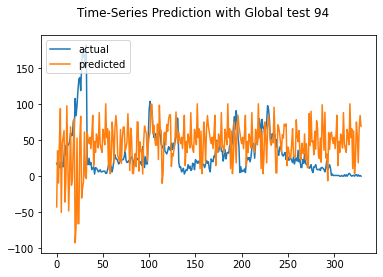

Test MAE: 35.552
Test RMSE: 43.182
Test sMAPE: 98.303
Test R Squared: -0.930
{'mae': 35.552438045033455, 'rmse': 43.18242429162575, 'smape': 98.30261864889344, 'r2': -0.929550023965863}


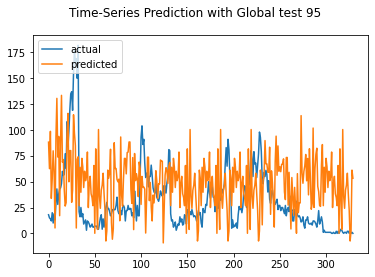

Test MAE: 36.143
Test RMSE: 46.010
Test sMAPE: 95.632
Test R Squared: -1.191
{'mae': 36.14295044270429, 'rmse': 46.01041410669598, 'smape': 95.63204288672581, 'r2': -1.1905556251838312}


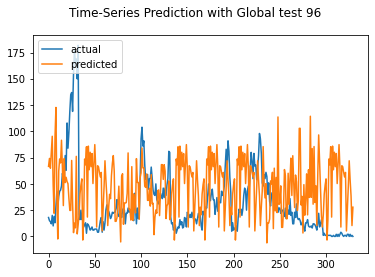

Test MAE: 37.967
Test RMSE: 51.478
Test sMAPE: 98.211
Test R Squared: -1.742
{'mae': 37.96674101678937, 'rmse': 51.47819873585135, 'smape': 98.2112889654271, 'r2': -1.7421340780535246}


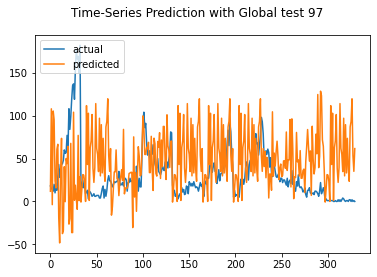

Test MAE: 32.997
Test RMSE: 41.399
Test sMAPE: 96.982
Test R Squared: -0.773
{'mae': 32.99737317074429, 'rmse': 41.39914850192416, 'smape': 96.98168617799499, 'r2': -0.7734739716572447}


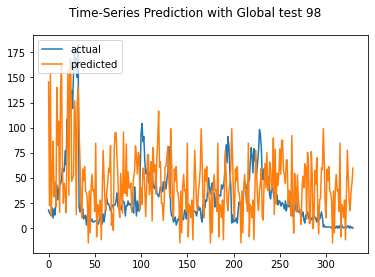

Test MAE: 37.283
Test RMSE: 44.245
Test sMAPE: 94.524
Test R Squared: -1.026
{'mae': 37.28287980411992, 'rmse': 44.24452013538649, 'smape': 94.52448855527956, 'r2': -1.0256340099185715}


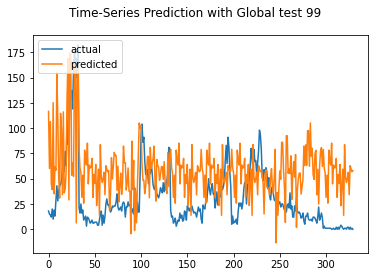

rmse : average=45.741, std=4.133
mae : average=36.860, std=3.479
smape : average=96.651, std=4.390
r2 : average=-1.183, std=0.406


([45.741397343952386, 4.132963491306261],
 [36.86031799248403, 3.4787909236498504],
 [96.65146019932976, 4.389878410257474],
 [-1.1826899699476208, 0.4057992824930324])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]


calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')